In [1]:
# flag to modify everything to run better on Colab; change it to true if you want to run on colab
use_colab = False
# use_colab = True

In [2]:
# [COLAB] uncomment for running on colab
# !pip install -e .

In [ ]:
# [COLAB] mount your Google Drive to access the zip file
from google.colab import drive
drive.mount('/content/drive' )

In [ ]:
# [COLAB] unzip data
# !unzip /content/drive/MyDrive/CS_7641_ML_Project/combined.zip

In [2]:
import os

import torch

from runner import Trainer
from optimizer import get_optimizer
from simple_net import SimpleNet
from simple_net_final import SimpleNetFinal
from my_resnet import MyResNet18
from multilabel_resnet import MultilabelResNet18
from my_optimal_net import OptimalNet
from data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from stats_helper import compute_mean_and_std
from confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)
from dl_utils import save_trained_model_weights

%load_ext autoreload
%autoreload 2

/home/jer/.local/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
is_cuda = True
is_cuda = (
    is_cuda and torch.cuda.is_available()
)  # will turn off cuda if the machine doesnt have a GPU

In [18]:
# CHANGE TO YOUR DIRECTORIES TO COMPUTE MEAN AND STD OF DATASET
data_path = '/media/jer/data2/state-farm-distracted-driver-detection/imgs/train/combined/train/' if not use_colab else "./combined/train/"
model_path = "../model_checkpoints/" if not use_colab else "./model_checkpoints/"

In [ ]:
# dataset_mean, dataset_std = compute_mean_and_std(data_path)
dataset_mean, dataset_std = 0.36668006, 0.51483374

In [37]:
inp_size = (224, 224)

In [38]:
my_resnet = MyResNet18()
print(my_resnet)
print(sum(p.numel() for p in my_resnet.parameters()))

MyResNet18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [39]:
optimizer_config = {"optimizer_type": "sgd", "lr": 5e-3, "weight_decay": 0, "momentum": 0.9} # Train Accuracy: 0.7549 Validation Accuracy: 0.3928

In [40]:
my_resnet = MyResNet18()
optimizer = get_optimizer(my_resnet, optimizer_config)

# # loading from colab for confusion matrices
# path = "/home/jer/grad/CV/project-4/src/vision/trained_MyResNet18_final.pt"
# my_resnet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
# my_resnet.load_state_dict(torch.load(path))


trainer = Trainer(
    data_dir=data_path,
    model=my_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "resnet18"),
    train_data_transforms=get_all_transforms(inp_size, dataset_mean, dataset_std),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, dataset_mean, dataset_std),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
)

In [ ]:
%%time
# trainer.run_training_loop(num_epochs=25)
trainer.run_training_loop(num_epochs=5)

# trainer.validate()

Epoch:1 Train Loss:1.3709 Val Loss: 2.0382 Train Accuracy: 0.5333 Validation Accuracy: 0.3670
Epoch:2 Train Loss:0.7897 Val Loss: 2.4790 Train Accuracy: 0.7369 Validation Accuracy: 0.3325


In [ ]:
# GRID SEARCH
# optimizer_config = {"optimizer_type": "sgd", "lr": 1e-3, "weight_decay": 2.5e-2, "momentum": 0.9}
# regularizating: higher decay = punishing high weights more
weight_decays = [0, 1e-8, 1e-6, 1e-4]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]


best_lr = None
best_weight_decay = None
best_val_acc = 0

for weight_decay in weight_decays:
  for learning_rate in learning_rates:
    
    optimizer_config = {"optimizer_type": "sgd", "lr": learning_rate, "weight_decay": weight_decay, "momentum": 0.9}
    
    my_resnet = MyResNet18()
    optimizer = get_optimizer(my_resnet, optimizer_config)

    trainer = Trainer(
        data_dir=data_path,
        model=my_resnet,
        optimizer=optimizer,
        model_dir=os.path.join(model_path, "resnet18"),
        train_data_transforms=get_all_transforms(inp_size),
        val_data_transforms=get_fundamental_normalization_transforms(
            inp_size),
        batch_size=32,
        load_from_disk=False,
        cuda=is_cuda,
)
    
    print("Learning Rate: ", learning_rate)
    print("Weight Decay: ", weight_decay)
    trainer.run_training_loop(num_epochs=5)
    train_accuracy = trainer.train_accuracy_history[-1]
    validation_accuracy = trainer.validation_accuracy_history[-1]
    print("Train Accuracy = {}; Validation Accuracy = {}".format(train_accuracy, validation_accuracy))
    
    if validation_accuracy > best_val_acc:
      best_lr = learning_rate
      best_weight_decay = weight_decay
      best_val_acc = validation_accuracy

    trainer.plot_loss_history()
    trainer.plot_accuracy()


print("best learning rate: ", best_lr)
print("best weight decay: ", best_weight_decay)
print("best validation accuracy: ", best_val_acc)

In [ ]:
trainer.validate()

Like both previous sections, you are required to pass a threshold of **85%** for this part. Copy the plots and values onto the report and answer questions accordingly.

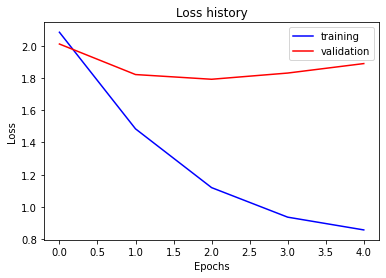

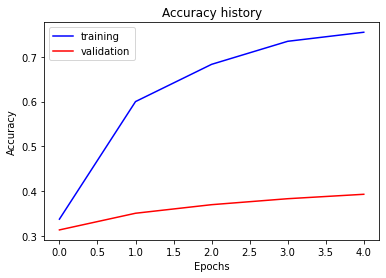

In [25]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

### Save Trained MyResnet18 model

In [ ]:
save_trained_model_weights(my_resnet, out_dir="./")

### Visualize and Analyze Confusion Matrix

In [ ]:
generate_and_plot_confusion_matrix(my_resnet, trainer.val_dataset, use_cuda=is_cuda)